Setup and get UPWINS data

In [31]:
# Install required packages if not already installed
# !pip install spectral numpy

import spectral.io.envi as envi
import numpy as np
import os
import matplotlib.pyplot as plt
import random
import pandas as pd
import re
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.utils.prune as prune
import copy
import time

random.seed(24)
np.random.seed(24)

# Adjust path if needed to where you cloned the repo
hdr_file = 'UPWINS_4_16_2024.hdr'
sli_file = hdr_file.replace('.hdr', '.sli')  # assumes same base name

# Load library
lib = envi.open(hdr_file, sli_file)

# Extract basic info
wl = np.asarray(lib.bands.centers)
names = lib.names
spectra = lib.spectra

print(f"Loaded {len(names)} spectra.")
print(f"Wavelengths: {len(wl)} bands from {np.min(wl)} nm to {np.max(wl)} nm")


Loaded 938 spectra.
Wavelengths: 2151 bands from 350.0 nm to 2500.0 nm


In [32]:
# Define what counts as unhealthy
unhealthy_codes = ['R', 'S', 'LLRZ', 'D', 'MX']
healthy_code = 'H'

healthy_indices = []
unhealthy_indices = []
discarded = []

def extract_health_tag(segment):
    """Extract the leading letters from the 4th part of the name."""
    match = re.match(r'^([A-Z]+)', segment)
    return match.group(1) if match else None

for i, name in enumerate(lib.names):
    parts = name.split('_')
    if len(parts) < 5:
        discarded.append(i)
        continue
    tag = extract_health_tag(parts[4].upper())
    if tag == healthy_code:
        healthy_indices.append(i)
    elif tag in unhealthy_codes:
        unhealthy_indices.append(i)
    else:
        discarded.append(i)

print(f"Healthy spectra:   {len(healthy_indices)}")
print(f"Unhealthy spectra: {len(unhealthy_indices)}")
print(f"Discarded spectra: {len(discarded)}")


Healthy spectra:   177
Unhealthy spectra: 44
Discarded spectra: 717


Generate Ground Truths

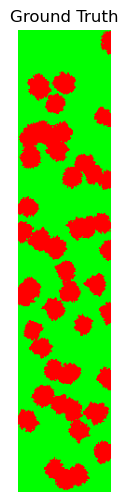

In [33]:
def generate_ground_truth_clustered(height=100, width=100, n_images=1):
    def grow_cluster(gt, H, W, target_count):
        """
        Grow clusters until the number of True pixels reaches target_count.
        """
        count = np.sum(gt)
        while count < target_count:
            new_gt = gt.copy()
            for i in range(H):
                for j in range(W):
                    if gt[i, j]:
                        # Try to expand to neighbors
                        for ni, nj in [(i-1,j), (i+1,j), (i,j-1), (i,j+1)]:
                            if 0 <= ni < H and 0 <= nj < W and not gt[ni, nj]:
                                if random.random() < 0.4:  # Probability to grow
                                    new_gt[ni, nj] = True
            gt = new_gt
            count = np.sum(gt)
        return gt

    def remove_isolated(gt, H, W):
        """
        Remove isolated True pixels (no True neighbors).
        """
        cleaned = gt.copy()
        for i in range(H):
            for j in range(W):
                if gt[i, j]:
                    neighbors = [
                        (i-1, j), (i+1, j), (i, j-1), (i, j+1),
                        (i-1, j-1), (i-1, j+1), (i+1, j-1), (i+1, j+1)
                    ]
                    if not any(
                        0 <= ni < H and 0 <= nj < W and gt[ni, nj]
                        for ni, nj in neighbors
                    ):
                        cleaned[i, j] = False
        return cleaned

    def generate_single_mask(H, W):
        gt = np.zeros((H, W), dtype=bool)
        seed_count = int(H * W * 0.001)
        target_count = int(H * W * 0.3)

        # Seed initial True pixels
        indices = np.unravel_index(np.random.choice(H * W, seed_count, replace=False), (H, W))
        gt[indices] = True

        # Grow clusters to target ratio
        gt = grow_cluster(gt, H, W, target_count)

        # Remove isolated True pixels
        gt = remove_isolated(gt, H, W)

        return gt

    return [generate_single_mask(height, width) for _ in range(n_images)]


def visualize_ground_truth(gt_array, title="Ground Truth"):
    """
    Display a ground truth array with True=red and False=green.
    """
    img = np.zeros((gt_array.shape[0], gt_array.shape[1], 3), dtype=np.uint8)
    img[gt_array] = [255, 0, 0]    # Red for True
    img[~gt_array] = [0, 255, 0]   # Green for False

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

gt_list = generate_ground_truth_clustered(height=500, width=100, n_images=25)
visualize_ground_truth(gt_list[0])


In [35]:
# Parameters
window_size = 4  # n × 1
stride = window_size

def extract_windows_and_labels(cube_list, gt_list, window_size=4, stride=4):
    X = []
    y = []
    for cube, gt in zip(cube_list, gt_list):
        H, W, B = cube.shape
        for col in range(W):
            for row_start in range(0, H - window_size + 1, stride):
                window = cube[row_start:row_start + window_size, col, :]
                label_window = gt[row_start:row_start + window_size, col]

                avg_spectrum = np.mean(window, axis=0)  # Shape (B,)
                label = int(np.sum(label_window) >= (window_size / 2))  # Majority voting

                X.append(avg_spectrum)
                y.append(label)
    return np.array(X), np.array(y)
class VegNet(nn.Module):
    def __init__(self, input_size=2151, hidden_size=128):
        super(VegNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()  # for binary classification
        )

    def forward(self, x):
        return self.model(x)
    
# Extract data
X, y = extract_windows_and_labels(hsi_cubes, gt_list, window_size)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.7, stratify=y
)

print(f"Train samples: {len(X_train)}, Test samples: {len(X_test)}")

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# DataLoaders
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64)

Train samples: 93750, Test samples: 218750


In [36]:
# Save test data in same folder as models
os.makedirs("deploy_models", exist_ok=True)
torch.save(X_test_tensor, "deploy_models/X_test.pt")
torch.save(y_test_tensor, "deploy_models/y_test.pt")
print("Test Data Saved")


Test Data Saved


Biuld Models

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VegNet().to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 10

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {running_loss/len(train_loader):.4f}")


Epoch 1/10, Loss: 0.3349
Epoch 2/10, Loss: 0.1841
Epoch 3/10, Loss: 0.1554
Epoch 4/10, Loss: 0.1378
Epoch 5/10, Loss: 0.1300
Epoch 6/10, Loss: 0.1289
Epoch 7/10, Loss: 0.1240
Epoch 8/10, Loss: 0.1220
Epoch 9/10, Loss: 0.1183
Epoch 10/10, Loss: 0.1142


C:\Users\arrow\AppData\Local\Temp\ipykernel_19240\4279379108.py:64: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


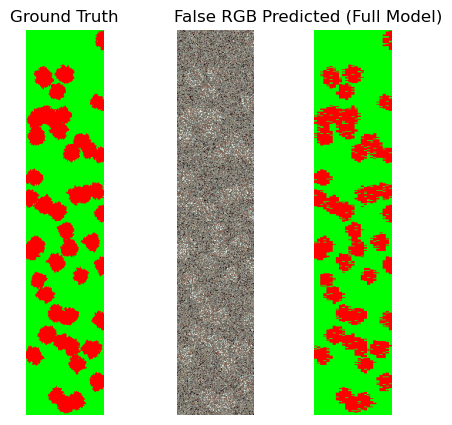

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def show_comparison(hsi_cube, gt_array, model, window_size=4, device='cpu'):
    H, W, B = hsi_cube.shape
    prediction_img = np.zeros((H, W, 3), dtype=np.uint8)
    correctness_img = np.zeros((H, W, 3), dtype=np.uint8)

    # Step 1: RGB Composite
    rgb = np.stack([hsi_cube[:, :, b] for b in (30, 50, 80)], axis=2)
    rgb = (rgb - np.min(rgb)) / (np.max(rgb) - np.min(rgb))  # normalize to 0–1

    # Step 2: Ground Truth (Red=True, Green=False)
    gt_rgb = np.zeros((H, W, 3), dtype=np.uint8)
    gt_rgb[gt_array] = [255, 0, 0]
    gt_rgb[~gt_array] = [0, 255, 0]

    # Step 3 & 4: Prediction + Correctness
    model.eval()
    with torch.no_grad():
        for row in range(H):
            for col in range(0, W - window_size + 1, window_size):
                window = hsi_cube[row, col:col + window_size, :]
                mean_spectrum = np.mean(window, axis=0)
                input_tensor = torch.tensor(mean_spectrum, dtype=torch.float32).unsqueeze(0).to(device)
                output = model(input_tensor)
                pred = int((output > 0.5).item())

                # Majority voting from ground truth window
                label_window = gt_array[row, col:col + window_size]
                true_label = int(np.sum(label_window) >= (window_size / 2))

                color_pred = [255, 0, 0] if pred else [0, 255, 0]
                prediction_img[row, col:col + window_size] = color_pred

                # Light gray if correct, black if wrong
                color_correct = [200, 200, 200] if pred == true_label else [0, 0, 0]
                correctness_img[row, col:col + window_size] = color_correct

    # Step 5: Plot all 4
    plt.figure(figsize=(5, 5))

    plt.subplot(1, 3, 2)
    plt.imshow(rgb)
    plt.title("False RGB")
    plt.axis("off")

    plt.subplot(1, 4, 1)
    plt.imshow(gt_rgb)
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(prediction_img)
    plt.title("Predicted (Full Model)")
    plt.axis("off")

    #plt.subplot(1, 4, 4)
    #plt.imshow(correctness_img)
    #plt.title("Prediction Accuracy Map")
    #plt.axis("off")

    plt.tight_layout()
    plt.show()



# ---- Load and Run the Full Model ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create and load the full (unpruned) model
model = VegNet(hidden_size=128).to(device)
model.load_state_dict(torch.load("deploy_models/vegnet_pruned_0.pt", map_location=device))


# Run the visualization
show_comparison(hsi_cubes[0], gt_list[0], model, window_size=4, device=device)


Prune Models

In [39]:
import torch.nn.utils.prune as prune
import copy
import torch.nn as nn

# Define pruning levels
pruning_levels = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 99]
pruned_models = {}

# Re-train base model from scratch
base_model = VegNet().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(base_model.parameters(), lr=1e-3)

# Full training of base model
n_epochs = 10
for epoch in range(n_epochs):
    base_model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = base_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Helper: Build a new model from the surviving neurons
def rebuild_model_from_pruned(pruned_model):
    layers = list(pruned_model.model.children())
    fc1 = layers[0]
    relu = layers[1]
    fc2 = layers[2]

    # Properly access the pruning mask
    mask = dict(fc1.named_buffers())['weight_mask'].detach().cpu().numpy()

    # Keep only neurons (rows) with nonzero weights
    active_indices = [i for i, row in enumerate(mask) if row.sum() > 0]
    new_hidden_size = len(active_indices)

    # Create new smaller model
    new_model = nn.Sequential(
        nn.Linear(fc1.in_features, new_hidden_size),
        nn.ReLU(),
        nn.Linear(new_hidden_size, fc2.out_features),
        nn.Sigmoid()
    )
    new_model = new_model.to(device)

    # Copy weights for remaining neurons
    with torch.no_grad():
        new_model[0].weight.copy_(fc1.weight[active_indices])
        new_model[0].bias.copy_(fc1.bias[active_indices])
        new_model[2].weight.copy_(fc2.weight[:, active_indices])
        new_model[2].bias.copy_(fc2.bias)

    return new_model


# Function to apply structured pruning and fine-tune
def structured_prune_and_finetune_and_rebuild(model, amount, finetune_epochs=3):
    pruned = copy.deepcopy(model)
    
    for name, module in pruned.named_modules():
        if isinstance(module, nn.Linear):
            prune.ln_structured(module, name="weight", amount=amount, n=1, dim=0)
    
    optimizer = torch.optim.Adam(pruned.parameters(), lr=1e-4)
    for _ in range(finetune_epochs):
        pruned.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = pruned(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Physically rebuild model with reduced size
    rebuilt = rebuild_model_from_pruned(pruned)
    return rebuilt

# Prune and rebuild at each level
for level in pruning_levels:
    if level == 0:
        pruned_models[level] = copy.deepcopy(base_model)
    else:
        print(f"Structured pruning {level}% of neurons...")
        pruned_model = structured_prune_and_finetune_and_rebuild(base_model, level / 100.0)
        pruned_models[level] = pruned_model


Structured pruning 5% of neurons...
Structured pruning 10% of neurons...
Structured pruning 15% of neurons...
Structured pruning 20% of neurons...
Structured pruning 25% of neurons...
Structured pruning 30% of neurons...
Structured pruning 35% of neurons...
Structured pruning 40% of neurons...
Structured pruning 45% of neurons...
Structured pruning 50% of neurons...
Structured pruning 55% of neurons...
Structured pruning 60% of neurons...
Structured pruning 65% of neurons...
Structured pruning 70% of neurons...
Structured pruning 75% of neurons...
Structured pruning 80% of neurons...
Structured pruning 85% of neurons...
Structured pruning 90% of neurons...
Structured pruning 95% of neurons...
Structured pruning 99% of neurons...


Pruning: 0% | Accuracy: 95.75% | Time: 4.75s | Nodes: 128
Pruning: 5% | Accuracy: 96.51% | Time: 4.47s | Nodes: 122
Pruning: 10% | Accuracy: 96.95% | Time: 4.23s | Nodes: 115
Pruning: 15% | Accuracy: 97.01% | Time: 4.24s | Nodes: 109
Pruning: 20% | Accuracy: 97.07% | Time: 4.10s | Nodes: 102
Pruning: 25% | Accuracy: 97.20% | Time: 4.10s | Nodes: 96
Pruning: 30% | Accuracy: 97.20% | Time: 4.53s | Nodes: 90
Pruning: 35% | Accuracy: 96.52% | Time: 4.32s | Nodes: 83
Pruning: 40% | Accuracy: 97.18% | Time: 4.13s | Nodes: 77
Pruning: 45% | Accuracy: 97.20% | Time: 3.98s | Nodes: 70
Pruning: 50% | Accuracy: 97.19% | Time: 3.68s | Nodes: 64
Pruning: 55% | Accuracy: 67.18% | Time: 3.97s | Nodes: 58
Pruning: 60% | Accuracy: 67.18% | Time: 3.82s | Nodes: 51
Pruning: 65% | Accuracy: 67.18% | Time: 3.93s | Nodes: 45
Pruning: 70% | Accuracy: 67.18% | Time: 4.40s | Nodes: 38
Pruning: 75% | Accuracy: 67.18% | Time: 4.79s | Nodes: 32
Pruning: 80% | Accuracy: 67.18% | Time: 4.83s | Nodes: 26
Pruning: 85

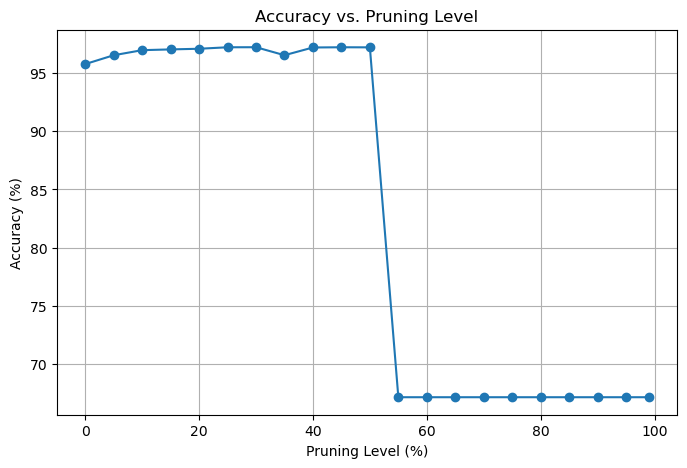

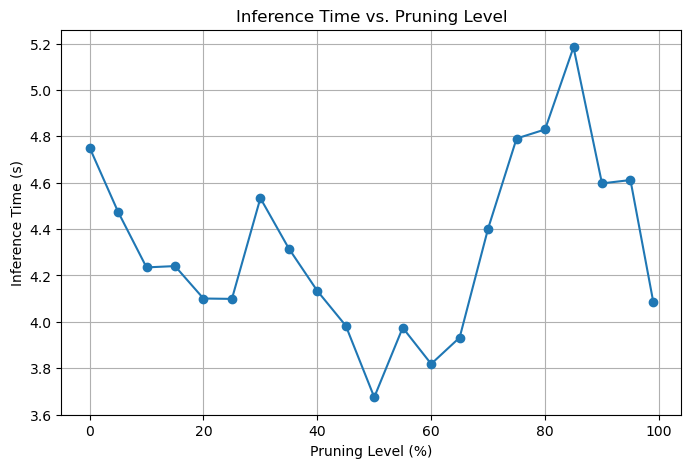

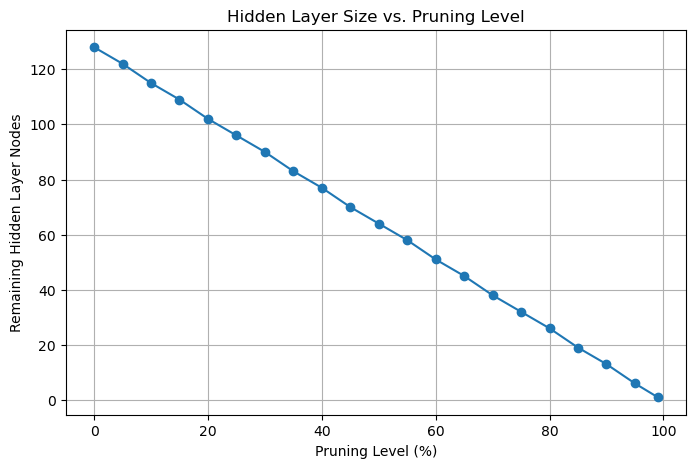

In [40]:
def evaluate_model_with_timing(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    start_time = time.time()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    total_time = time.time() - start_time
    accuracy = 100 * correct / total
    return accuracy, total_time

# Collect results
results = []

for level, model in pruned_models.items():
    model.to(device)

    # Evaluate accuracy and inference time
    acc, inf_time = evaluate_model_with_timing(model, test_loader)

    # Count remaining nodes in hidden layer (after structured pruning)
    if isinstance(model, nn.Sequential):
        linear1 = list(model.children())[0]
    else:
        linear1 = list(model.model.children())[0]

    weight = linear1.weight
    if hasattr(weight, 'mask'):
        num_nodes = int(weight.mask.sum().item())
    else:
        num_nodes = weight.shape[0]  # All nodes retained (no pruning)

    results.append((level, acc, inf_time, num_nodes))
    print(f"Pruning: {level}% | Accuracy: {acc:.2f}% | Time: {inf_time:.2f}s | Nodes: {num_nodes}")

# Sort results
results.sort()
levels, accuracies, times, node_counts = zip(*results)

# Plot 1: Accuracy vs. Pruning Level
plt.figure(figsize=(8, 5))
plt.plot(levels, accuracies, marker='o')
plt.xlabel('Pruning Level (%)')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs. Pruning Level')
plt.grid(True)
plt.show()

# Plot 2: Inference Time vs. Pruning Level
plt.figure(figsize=(8, 5))
plt.plot(levels, times, marker='o')
plt.xlabel('Pruning Level (%)')
plt.ylabel('Inference Time (s)')
plt.title('Inference Time vs. Pruning Level')
plt.grid(True)
plt.show()

# Plot 3: Hidden Layer Nodes vs. Pruning Level
plt.figure(figsize=(8, 5))
plt.plot(levels, node_counts, marker='o')
plt.xlabel('Pruning Level (%)')
plt.ylabel('Remaining Hidden Layer Nodes')
plt.title('Hidden Layer Size vs. Pruning Level')
plt.grid(True)
plt.show()

In [41]:
os.makedirs("deploy_models", exist_ok=True)

# Save models
for level, model in pruned_models.items():
    torch.save(model.state_dict(), f"deploy_models/vegnet_pruned_{level}.pt")

# Write sizes
with open("deploy_models/model_sizes.txt", "w") as f:
    for level, model in pruned_models.items():
        first_layer = list(model.children())[0]
        if isinstance(first_layer, nn.Linear):
            hidden_size = first_layer.out_features
            f.write(f"Level {level}%: {hidden_size} hidden nodes\n")
        else:
            f.write(f"Level {level}%: Could not determine hidden size\n")

# Export ONNX
dummy_input = torch.randn(1, 2151).to(device)
for level, model in pruned_models.items():
    torch.onnx.export(
        model, dummy_input,
        f"deploy_models/vegnet_pruned_{level}.onnx",
        input_names=['input'], output_names=['output'],
        opset_version=11
    )
print("Models Saved")

Models Saved


After Nano Processing

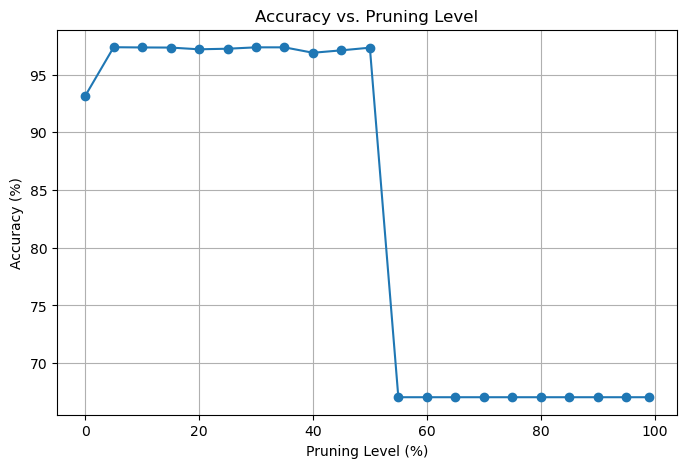

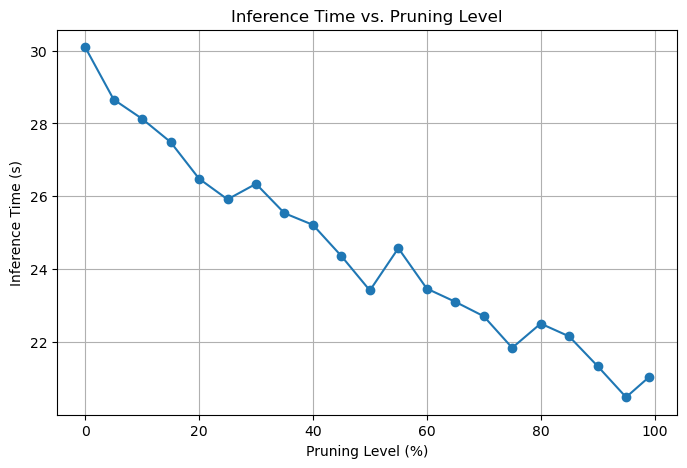

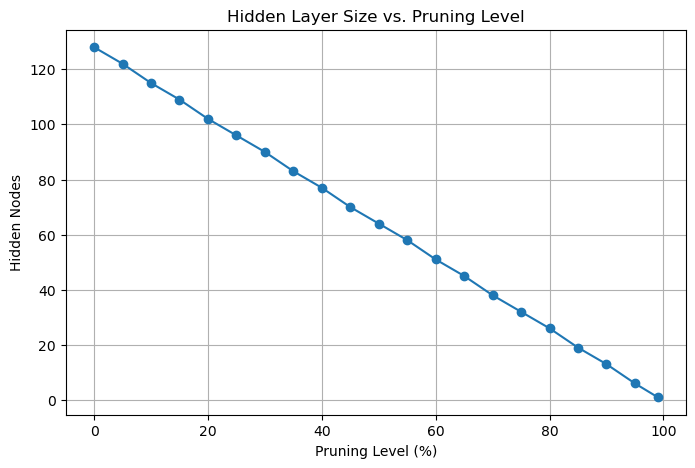

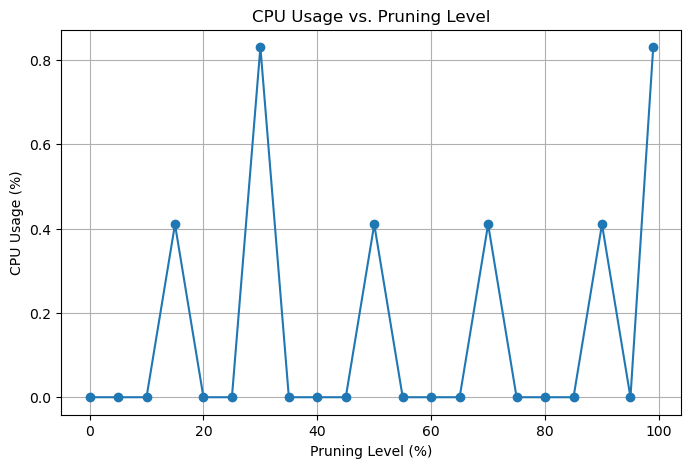

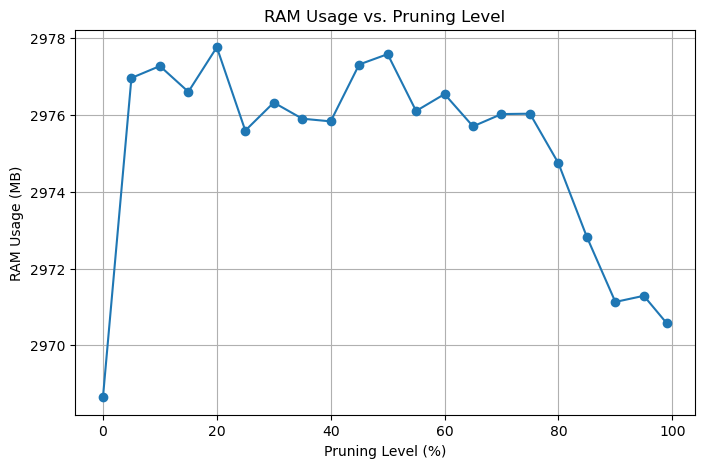

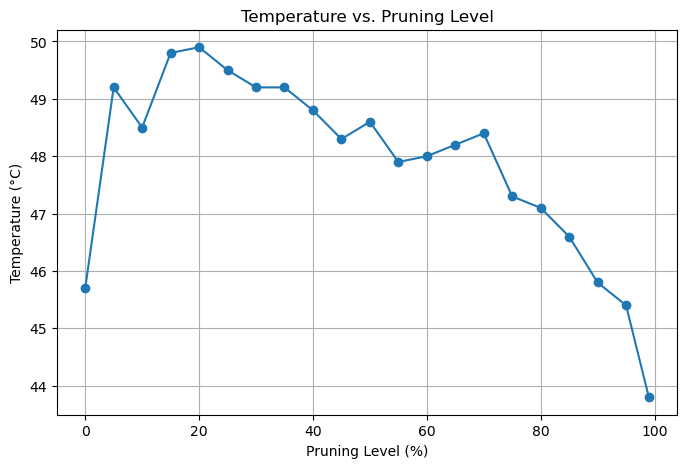

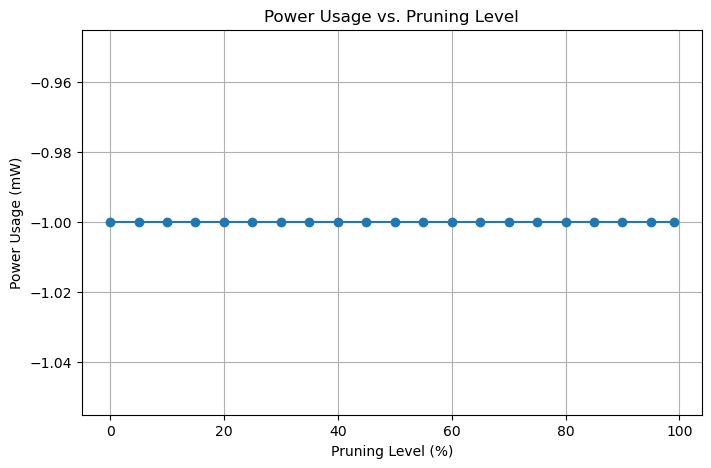

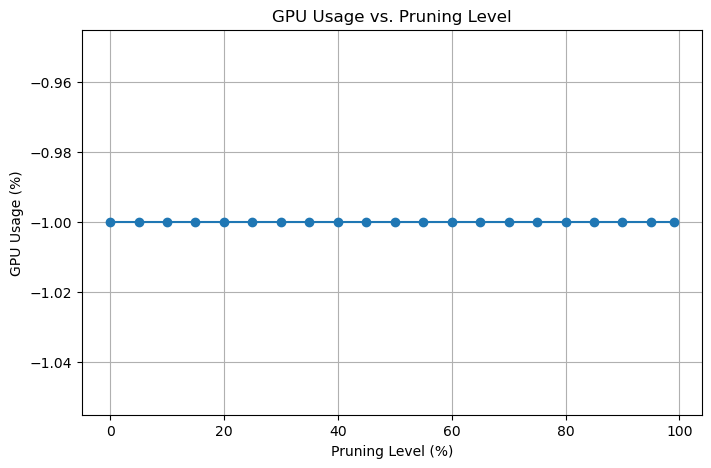

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import re

# --- Load and Parse Results ---
data = []
with open("deploy_models/results5.txt", "r", encoding="utf-8", errors="replace") as f:
    for line in f:
        parts = line.strip().split(" | ")
        if len(parts) != 9:
            continue  # Skip malformed lines

        try:
            pruning = int(re.search(r"\d+", parts[0]).group())
            accuracy = float(re.search(r"[\d.]+", parts[1]).group())
            time = float(re.search(r"[\d.]+", parts[2]).group())
            nodes = int(re.search(r"\d+", parts[3]).group())
            cpu = float(re.search(r"[\d.]+", parts[4]).group())
            ram = float(re.search(r"[\d.]+", parts[5]).group())
            temp_match = re.search(r"-?[\d.]+", parts[6])
            temp = float(temp_match.group()) if temp_match else -1.0
            power_match = re.search(r"-?\d+", parts[7])
            power = float(power_match.group()) if power_match else -1.0
            gpu_match = re.search(r"-?\d+", parts[8])
            gpu = float(gpu_match.group()) if gpu_match else -1.0

            data.append((pruning, accuracy, time, nodes, cpu, ram, temp, power, gpu))

        except Exception as e:
            print(f"Skipping line due to error: {e}")
            print(f"Line was: {line}")

# Create DataFrame
df = pd.DataFrame(data, columns=["Pruning", "Accuracy", "Time", "Nodes", "CPU", "RAM", "Temp", "Power", "GPU"]) 
df.sort_values("Pruning", inplace=True)

# --- Plotting Function ---
def make_plot(y, ylabel, title):
    #print(title, ":", df[y])  # debug output
    plt.figure(figsize=(8, 5))
    plt.plot(df["Pruning"], df[y], marker='o')
    plt.xlabel("Pruning Level (%)")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.show()

# --- Plots ---
make_plot("Accuracy", "Accuracy (%)", "Accuracy vs. Pruning Level")
make_plot("Time", "Inference Time (s)", "Inference Time vs. Pruning Level")
make_plot("Nodes", "Hidden Nodes", "Hidden Layer Size vs. Pruning Level")
make_plot("CPU", "CPU Usage (%)", "CPU Usage vs. Pruning Level")
make_plot("RAM", "RAM Usage (MB)", "RAM Usage vs. Pruning Level")
make_plot("Temp", "Temperature (°C)", "Temperature vs. Pruning Level")
make_plot("Power", "Power Usage (mW)", "Power Usage vs. Pruning Level")
make_plot("GPU", "GPU Usage (%)", "GPU Usage vs. Pruning Level")
